<a href="https://colab.research.google.com/github/ryuseonghan/TF2-Study/blob/master/naver_sentiment_movie_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# naver-sentiment-movie-rnn

Reference
- https://www.tensorflow.org/tutorials/keras/text_classification?hl=ko
- https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ko
- https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html
- https://wikidocs.net/44249

## Data Loading

In [0]:
import urllib
import pandas as pd

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f924bea4320>)

In [0]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

## Data Preprocessing

In [0]:
train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","")
test_data["document"] = test_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","")

In [5]:
train_data.loc[train_data['document'].duplicated()]

,id,document,label
593,6478189,,0
638,9364602,,0
1058,5890638,,0
1097,2062443,쵝오,1
1165,7508856,최고,1
...,...,...,...
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,,0
149987,7669621,재미있어요,1


In [0]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [7]:
train_data['document'].duplicated().values.any()

False

In [0]:
train_data.dropna(how='any', inplace=True)
test_data.dropna(how='any', inplace=True)

In [9]:
train_data.document.isnull().values.any(), test_data.document.isnull().values.any()

(False, False)

In [10]:
train_data[:3]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [11]:
test_data[:3]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0


## Tokenization

In [12]:
train_data["document"][0]

'아 더빙 진짜 짜증나네요 목소리'

In [0]:
def tokenize(text):
  return list(text)

train_text = [tokenize(text) for text in train_data["document"]]
test_text = [tokenize(text) for text in test_data["document"]]

In [0]:
reverse_word_index = ["<PAD>", "<UNK>"] + list(set([word for text in train_text for word in text]))
reverse_word_index = {wid: word for wid, word in enumerate(reverse_word_index)}

In [0]:
word_index = {word: wid for wid, word in reverse_word_index.items()}

In [16]:
import numpy as np

def encode_text(text, max_seq_len):
    coded = []
    for i in range(max_seq_len):
      if i < len(text):
        coded.append(word_index.get(text[i], word_index["<UNK>"]))
      else:
        coded.append(word_index["<PAD>"])
    return coded

def decode_text(coded):
    text = []
    for wid in coded:
      if wid != word_index["<PAD>"]:
          text.append(reverse_word_index.get(wid, "?"))
    return text

train_x = np.array([encode_text(text, 32) for text in train_text])
test_x = np.array([encode_text(text, 32) for text in test_text])

train_x.shape, test_x.shape

((144277, 32), (49997, 32))

In [17]:
"|".join(decode_text(train_x[0]))

'아| |더|빙| |진|짜| |짜|증|나|네|요| |목|소|리'

In [18]:
train_y = np.array(train_data["label"])
test_y = np.array(test_data["label"])
train_y, test_y

(array([0, 1, 0, ..., 0, 1, 0]), array([1, 0, 0, ..., 0, 0, 0]))

## Model Building

In [19]:
from tensorflow import keras

vocab_size = len(word_index)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 32, mask_zero=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.GRU(64)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='tanh'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          83040     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [0]:
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training

In [0]:
val_x = test_x[:1000]
val_y = test_y[:1000]

In [0]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))

train_dataset = train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(256)
val_dataset = val_dataset.batch(1000)

train_dataset = train_dataset.prefetch(4)

In [23]:
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1)

Epoch 1/20
564/564 [==============================] - 83s 148ms/step - loss: 0.5226 - accuracy: 0.7372 - val_loss: 0.4788 - val_accuracy: 0.7760
Epoch 2/20
564/564 [==============================] - 76s 135ms/step - loss: 0.4775 - accuracy: 0.7711 - val_loss: 0.4538 - val_accuracy: 0.7810
Epoch 3/20
564/564 [==============================] - 77s 137ms/step - loss: 0.4467 - accuracy: 0.7874 - val_loss: 0.4353 - val_accuracy: 0.7880
Epoch 4/20
564/564 [==============================] - 76s 136ms/step - loss: 0.4323 - accuracy: 0.7960 - val_loss: 0.4358 - val_accuracy: 0.8040
Epoch 5/20
564/564 [==============================] - 77s 137ms/step - loss: 0.4200 - accuracy: 0.8032 - val_loss: 0.4276 - val_accuracy: 0.8070
Epoch 6/20
564/564 [==============================] - 76s 135ms/step - loss: 0.4111 - accuracy: 0.8091 - val_loss: 0.4201 - val_accuracy: 0.8020
Epoch 7/20
564/564 [==============================] - 76s 136ms/step - loss: 0.4018 - accuracy: 0.8150 - val_loss: 0.4160 - val_ac

## Evaluation

In [24]:
model.predict([encode_text(tokenize("이거 잼있네"), 32)])[0]

array([0.92911977], dtype=float32)

In [25]:
model.predict([encode_text(tokenize("이거 졸잼이네"), 32)])[0]

array([0.90994024], dtype=float32)

In [26]:
model.predict([encode_text(tokenize("이거 개꿀잼"), 32)])[0]

array([0.9775113], dtype=float32)

In [27]:
model.predict([encode_text(tokenize("이거 노잼이네"), 32)])[0]

array([0.03209848], dtype=float32)

In [28]:
model.predict([encode_text(tokenize("완전 핵노잼"), 32)])[0]

array([0.01110437], dtype=float32)

In [29]:
model.predict([encode_text(tokenize("그냥 그래요"), 32)])[0]

array([0.15100455], dtype=float32)

In [30]:
results = model.evaluate(test_x, test_y, verbose=2)

1563/1563 - 11s - loss: 0.3963 - accuracy: 0.8201


In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

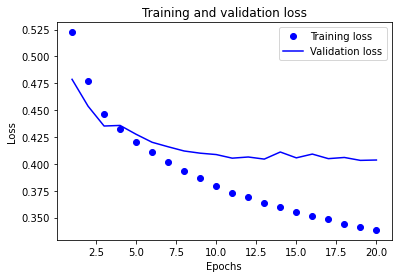

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

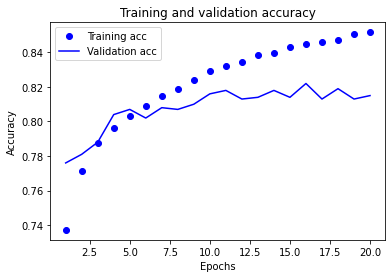

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()